In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import cv2

In [2]:
def show_image(img):
    plt.imshow(img, cmap="gray")
    plt.show()
    
def canny(image):
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    canny = cv2.Canny(blur,  50, 150)
    return canny

In [3]:
img = cv2.imread('foto_mesa.jpeg')

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 40, 255, cv2.THRESH_BINARY_INV)

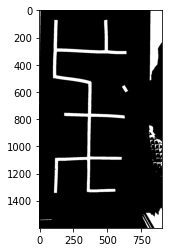

In [5]:
show_image(binary)

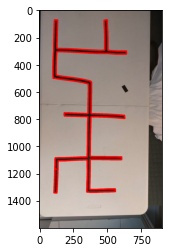

In [6]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Since all lines are connected they will be in the same contour, so just need to get the biggest contour
idx = np.argmax([c.size for c in contours])
contours = contours[idx]  # [x, y]

img_contours = cv2.drawContours(img.copy(), contours, -1, (255, 0, 0), 10)
plt.imshow(img_contours)

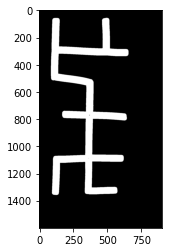

In [7]:
mask = np.zeros((1600, 901,3), dtype=np.uint8)
mask = cv2.drawContours(mask, contours, -1, (255, 255, 255), 30)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# dilate = cv2.dilate(mask, kernel, iterations=8)
# result = cv2.erode(mask, kernel, iterations=2)
show_image(mask)

In [8]:
# kernel = np.ones((5, 5), np.uint8)
# teste = cv2.erode(binary, kernel, iterations=4)
# contours, _ = cv2.findContours(teste, cv2.RETR_ETERNAL, cv2.CHAIN_APPROy_NONE)
# # Since all lines are connected they will be in the same contour, so just need to get the biggest contour
# idy = np.argmay([c.size for c in contours])
# contours = contours[idx]

# img_contours = cv2.drawContours(img.copy(), contours, -1, (255, 0, 0), 10)
# plt.imshow(img_contours)

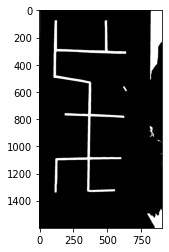

In [9]:
thresh = 150
min_line = 50
max_line = 100
bordas = cv2.erode(binary, kernel, iterations=4)
linhas = cv2.HoughLinesP(bordas, 1, np.pi / 180, thresh, minLineLength=min_line, maxLineGap=max_line)
bordas_copia = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)
for linha in linhas:
    x1, y1, x2, y2 = linha[0] # Retorna apenas dois pontos
    cv2.line(bordas_copia, (x1, y1), (x2, y2), (255, 255, 255), 3)
    
show_image(bordas_copia)

In [10]:
len(linhas)

219

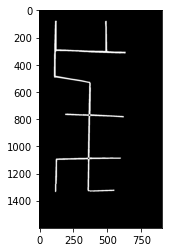

In [11]:
res = cv2.bitwise_and(mask, bordas_copia)
res = cv2.erode(res, kernel, iterations=3)
show_image(res)

In [12]:
res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
res.shape

(1600, 901)

In [13]:
thresh = 255
min_line = 150
max_line = 100
linhas = cv2.HoughLinesP(res, 1, np.pi / 100, thresh, minLineLength=min_line, maxLineGap=max_line)

58


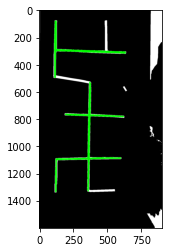

In [14]:
print(len(linhas))
teste = cv2.erode(binary, kernel, iterations=4)
b_c = cv2.cvtColor(teste, cv2.COLOR_GRAY2BGR)
for linha in linhas:
    x1, y1, x2, y2 = linha[0] # Retorna apenas dois pontos
    cv2.line(bordas_copia, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
show_image(bordas_copia)

In [15]:
import math
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

In [16]:
lines = cv2.HoughLinesP(res, 1, np.pi / 180, 50, None, 50, 10)
# bundler = HoughBundler(min_distance=10,min_angle=5)
bundler = HoughBundler(min_distance=10,min_angle=3)
lines = bundler.process_lines(lines)

In [17]:
len(lines)

11

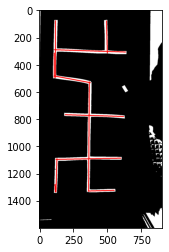

In [18]:
kernel = np.ones((5, 5), np.uint8)
teste = cv2.erode(res, kernel, iterations=4)
bordas_copia = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
for linha in lines:
    x1, y1, x2, y2 = linha[0] # Retorna apenas dois pontos
    cv2.line(bordas_copia, (x1, y1), (x2, y2), (255, 0, 0), 5)
show_image(bordas_copia)

In [19]:
lines

array([[[ 109,  483,  376,  533]],

       [[ 112,  291,  634,  308]],

       [[ 123, 1096,  599, 1087]],

       [[ 191,  768,  620,  781]],

       [[ 360, 1328,  551, 1323]],

       [[ 120,   78,  120,  495]],

       [[ 494,   79,  500,  315]],

       [[ 111,  315,  111,  494]],

       [[ 368,  526,  363, 1330]],

       [[ 131, 1090,  124, 1335]],

       [[ 117, 1278,  119, 1335]]], dtype=int32)

In [20]:
def biggest_distance(p1, p2):
    def euclidian_dist(p):
        return np.sqrt((p[0]-p[2])**2 + (p[1]-p[3])**2)
    final_point = deepcopy(p1)
    dist = euclidian_dist(p1)
    for ind, val in enumerate(p2):
        aux = deepcopy(final_point)
        aux[ind] = val
        new_dist = euclidian_dist(aux)
        if new_dist > dist:
            dist = new_dist
            final_point = aux
    
    final_point[::2].sort()
    final_point[1::2].sort()
    return final_point
    

In [21]:
from math import degrees, atan2
tol = 5
sorted_lines = deepcopy(linhas)
sorted_lines = sorted(sorted_lines, key=lambda x: x[0][1])
sorted_lines = sorted(sorted_lines, key=lambda x: x[0][0])
nova_linha = [sorted_lines[0]]
nova_linha[0][0][::2].sort()
nova_linha[0][0][1::2].sort()
for i, linha in enumerate(sorted_lines[1:]):
    linha[0][::2].sort()
    linha[0][1::2].sort()
    x1, y1, x2, y2 = linha[0]
    found = False
    for l in nova_linha:
        cx1, cy1, cx2, cy2 = l[0]
        first_point = np.isclose([x1, y1], [cx1, cy1], atol=tol).all()
        second_point = np.isclose([x2, y2], [cx2, cy2], atol=tol).all()
        # starts_in_x = x1 <= cx1 <= x2 or x1 <= cx2 <= x2 or cx1 <= x1 <= cx2 or cx1 <= x2 <= cx2
        # starts_in_y = y1 <= cy1 <= y2 or y1 <= cy2 <= y2 or cy1 <= y1 <= cy2 or cy1 <= y2 <= cy2
        if first_point or second_point:
            deg1 = degrees(atan2(l[0][2]-l[0][0], l[0][3]-l[0][1]))
            deg2 = degrees(atan2(linha[0][2]-linha[0][0], linha[0][3]-linha[0][1]))
            if not np.allclose([deg1], [deg2], atol=4):
                continue
            found = True
            r = biggest_distance(l[0], linha[0])
            deg2 = degrees(atan2(r[2]-r[0], r[3]-r[1]))
            if not np.allclose([deg1], [deg2], atol=4):
                continue
            l[0] = r
            break
    if not found:
        # print(i+1)
        nova_linha.append(linha)
nova_linha = np.array(nova_linha)

In [22]:
print(nova_linha.shape)
print(linhas.shape)

(13, 1, 4)
(58, 1, 4)


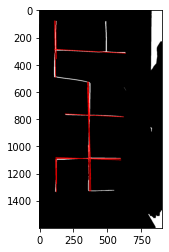

In [23]:
kernel = np.ones((5, 5), np.uint8)
teste = cv2.erode(binary, kernel, iterations=4)
bordas_copia = cv2.cvtColor(teste, cv2.COLOR_GRAY2BGR)
for linha in nova_linha:
    x1, y1, x2, y2 = linha[0] # Retorna apenas dois pontos
    cv2.line(bordas_copia, (x1, y1), (x2, y2), (255, 0, 0), 3)
show_image(bordas_copia)